In [1]:
import csv
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import seaborn as sn
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [2]:
start_date = pd.Timestamp('2011/01/24')
stop_date = pd.Timestamp('2015/12/13')
dept_enc = LabelEncoder()

In [3]:
def reload_data():
    global df
    df = pd.read_csv('employee_retention_data.csv')
    df.sort_values(['employee_id'],inplace=True)
    df['join_date'] = pd.to_datetime(df['join_date'])
    df['quit_date'] = pd.to_datetime(df['quit_date'])

In [4]:
def feature_engineer():
    global df
    # add salary averages
    comp_sal = df[['company_id','salary', 'dept']].groupby('company_id').mean().reset_index(level=['company_id']).rename(columns={'salary':'company_average_salary'})
    dept_sal = df[[ 'salary', 'dept']].groupby('dept').mean().reset_index(level=['dept']).rename(columns={'salary':'dept_average_salary'})
    dept_comp_sal = df[['company_id','salary', 'dept']].groupby(['dept', 'company_id']).mean().reset_index(level=['dept','company_id']).rename(columns={'salary':'dept_at_company_average_salary'})
    salary_means_df = dept_comp_sal.merge(dept_sal, on=['dept']).merge(comp_sal, on=['company_id'])
    df = df.merge(salary_means_df, on=['company_id', 'dept'])
    # compute some values
    df['dept_as_int'] = dept_enc.fit_transform(df['dept'])
    df['time_since_join'] = stop_date - df['join_date'] 
    df['time_until_quit'] = (df['quit_date'] - df['join_date']).dt.days
    df['last_employment_day'] = df['quit_date'].fillna(stop_date)
    df['duration'] = (df['last_employment_day'] - df['join_date']).dt.days
    df['seniority_at_end'] = df['seniority'] + (df['duration'] // 365)
    df['average_seniority'] = (df['seniority'] + df['seniority_at_end']) / 2
    df['salary/average_seniority'] = df['salary'] / df['average_seniority']
    df['quit'] = np.invert(df['quit_date'].isnull())
    df['company_average_salary_diff'] = df['salary'] - df['company_average_salary']
    df['dept_average_salary_diff'] = df['salary'] - df['dept_average_salary']
    df['dept_at_company_average_salary_diff'] = df['salary'] - df['dept_at_company_average_salary']

In [5]:
def split_quit():
    global df
    quit_df = df.where(df['quit']).dropna(how='all')
    stayed_df = df.where(df['quit'] == False).dropna(how='all')
    return quit_df, stayed_df

In [6]:
def get_comp(df, cid):
    return df.where(df['company_id'] == cid).dropna(how='all')

def get_dept(df, dept):
    return df.where(df['dept'] == dept).dropna(how='all')
    

In [7]:
def get_metrics_for_day(dframe, tstamp):
    comp_df = pd.DataFrame()
    comp_df['company_id'] = pd.Series(sorted(df['company_id'].unique())) 
    num_joined = df.where(df['join_date'] == tstamp).dropna(how='all')['company_id'].value_counts()
    num_quit = df.where(df['quit_date'] == tstamp).dropna(how='all')['company_id'].value_counts()
    num_joined_df = pd.DataFrame()
    num_joined_df['company_id'] = num_joined.index 
    num_joined_df['num_joined'] = num_joined
    num_quit_df = pd.DataFrame()
    num_quit_df['company_id'] = num_quit.index
    num_quit_df['num_quit'] = num_quit
    delta_df = comp_df.merge(how='left', on=['company_id'], right=num_joined_df)
    delta_df = delta_df.merge(how='left', on=['company_id'], right=num_quit_df)
    delta_df = delta_df.fillna(0)
    delta_df['employee_headcount'] = delta_df['num_joined'] - delta_df['num_quit']
    delta_df['day'] = tstamp
    del delta_df['num_quit']
    del delta_df['num_joined']
    return delta_df

def get_headcount_table(dframe):
    hcount_df = pd.DataFrame()
    current = start_date
    delta_df = get_metrics_for_day(dframe, current)
    current_total = delta_df['employee_headcount']
    relevant_dates = pd.Series(sorted(dframe['quit_date'].dropna().append(dframe['join_date'].dropna()).unique()))
    current += pd.DateOffset(1)
    count = 0
    for current in relevant_dates:
        delta_df = get_metrics_for_day(dframe, current)
        current_total += delta_df['employee_headcount']
        delta_df['employee_headcount'] = current_total
        hcount_df = pd.concat([hcount_df, delta_df], ignore_index=True)
        current += pd.DateOffset(1)
    return hcount_df


In [8]:
reload_data()
feature_engineer()
df.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'dept_at_company_average_salary', 'dept_average_salary',
       'company_average_salary', 'dept_as_int', 'time_since_join',
       'time_until_quit', 'last_employment_day', 'duration',
       'seniority_at_end', 'average_seniority', 'salary/average_seniority',
       'quit', 'company_average_salary_diff', 'dept_average_salary_diff',
       'dept_at_company_average_salary_diff'],
      dtype='object')

In [9]:
df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,dept_at_company_average_salary,dept_average_salary,company_average_salary,...,time_until_quit,last_employment_day,duration,seniority_at_end,average_seniority,salary/average_seniority,quit,company_average_salary_diff,dept_average_salary_diff,dept_at_company_average_salary_diff
0,36.0,4,data_science,29,226000.0,2012-04-09,2014-06-20,181749.103943,206885.893417,122721.14452,...,802.0,2014-06-20,802,31,30.0,7533.333333,True,103278.85548,19114.106583,44250.896057
1,6801.0,4,data_science,5,161000.0,2013-09-16,2015-10-09,181749.103943,206885.893417,122721.14452,...,753.0,2015-10-09,753,7,6.0,26833.333333,True,38278.85548,-45885.893417,-20749.103943
2,6808.0,4,data_science,26,230000.0,2013-08-26,NaT,181749.103943,206885.893417,122721.14452,...,NaN,2015-12-13,839,28,27.0,8518.518519,False,107278.85548,23114.106583,48250.896057
3,9560.0,4,data_science,11,135000.0,2011-12-27,2014-12-19,181749.103943,206885.893417,122721.14452,...,1088.0,2014-12-19,1088,13,12.0,11250.000000,True,12278.85548,-71885.893417,-46749.103943
4,15774.0,4,data_science,2,52000.0,2014-10-06,NaT,181749.103943,206885.893417,122721.14452,...,NaN,2015-12-13,433,3,2.5,20800.000000,False,-70721.14452,-154885.893417,-129749.103943
5,17248.0,4,data_science,6,165000.0,2013-02-25,2014-12-26,181749.103943,206885.893417,122721.14452,...,669.0,2014-12-26,669,7,6.5,25384.615385,True,42278.85548,-41885.893417,-16749.103943
6,28631.0,4,data_science,18,286000.0,2011-07-18,2012-09-07,181749.103943,206885.893417,122721.14452,...,417.0,2012-09-07,417,19,18.5,15459.459459,True,163278.85548,79114.106583,104250.896057
7,30656.0,4,data_science,22,238000.0,2011-11-22,2012-12-21,181749.103943,206885.893417,122721.14452,...,395.0,2012-12-21,395,23,22.5,10577.777778,True,115278.85548,31114.106583,56250.896057
8,31167.0,4,data_science,4,54000.0,2011-12-12,NaT,181749.103943,206885.893417,122721.14452,...,NaN,2015-12-13,1462,8,6.0,9000.000000,False,-68721.14452,-152885.893417,-127749.103943
9,34805.0,4,data_science,20,211000.0,2013-01-22,2014-11-21,181749.103943,206885.893417,122721.14452,...,668.0,2014-11-21,668,21,20.5,10292.682927,True,88278.85548,4114.106583,29250.896057


In [10]:
comp_dur = df[['company_id', 'dept','duration']].groupby('company_id').mean().reset_index(level=['company_id']).rename(columns={'duration':'company_average_duration'})
dept_dur = df[['dept','duration']].groupby('dept').mean().reset_index(level=['dept']).rename(columns={'duration':'dept_average_duration'})
dept_comp_dur = df[['company_id', 'dept','duration']].groupby(['dept', 'company_id']).mean().reset_index(level=['dept','company_id']).rename(columns={'duration':'dept_at_company_average_duration'})

In [11]:
hcount_df = get_headcount_table(df)
# hcount_df

In [12]:
hcount_df['day_num'] = (hcount_df['day'] - start_date).dt.days

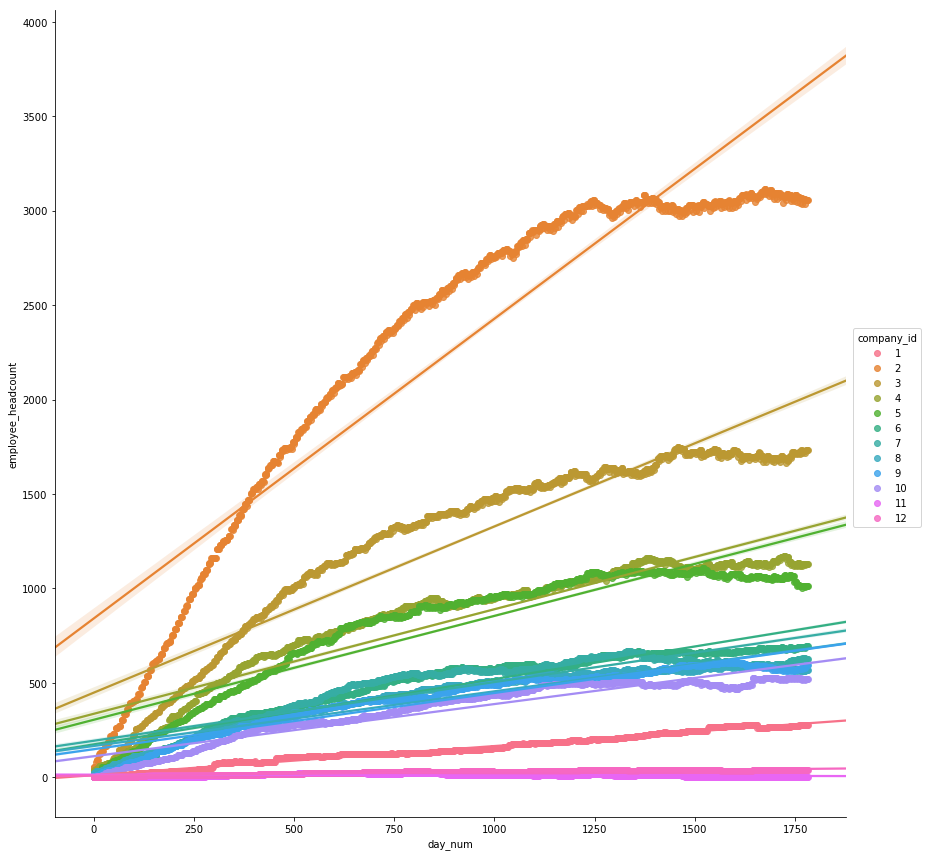

In [13]:
sn.lmplot(x='day_num', y='employee_headcount', data=hcount_df, hue='company_id', size=12)
plt.show()

# Growth Curves of the Companies
companies had very different growth rates

In [14]:
quit_df, stayed_df = split_quit()

In [15]:
depts = df['dept'].unique()
comp_ids = df['company_id'].unique()

In [16]:
ds_cid = get_dept(get_comp(df, 2),'data_science')


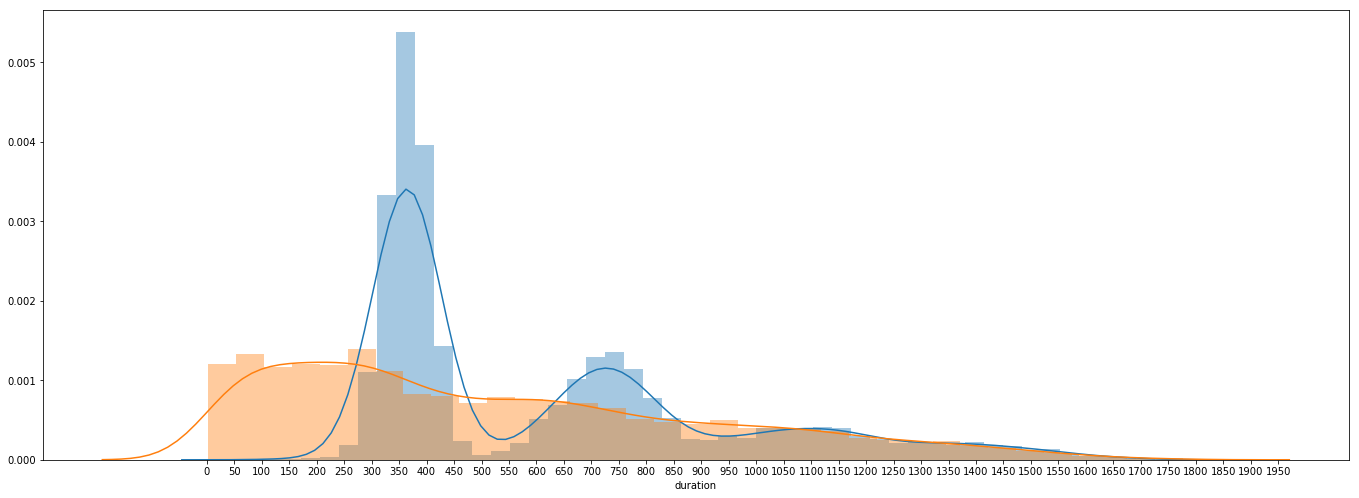

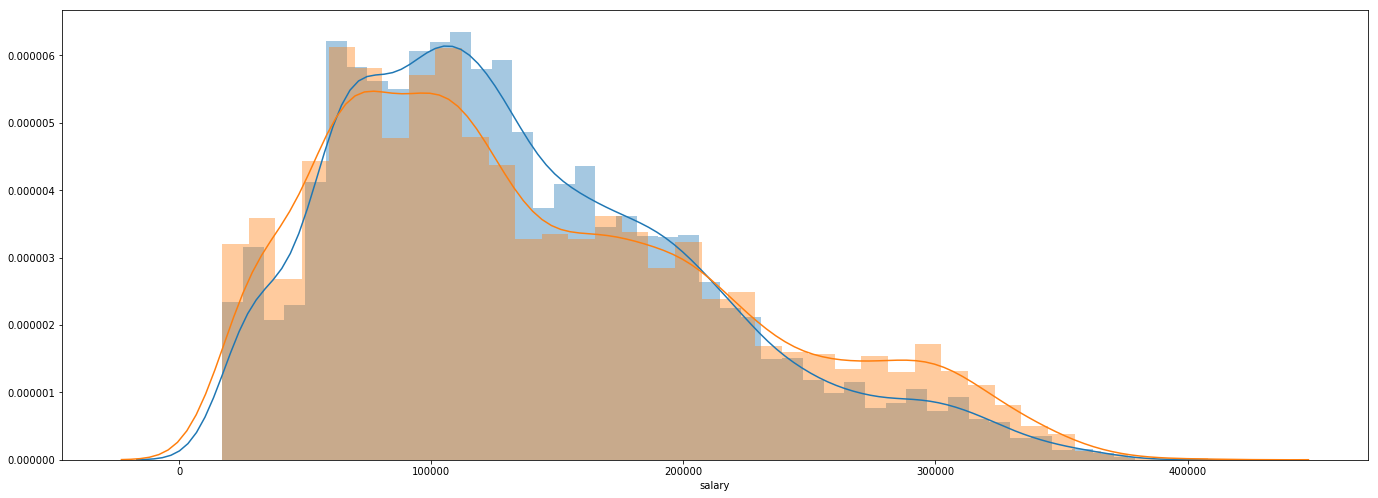

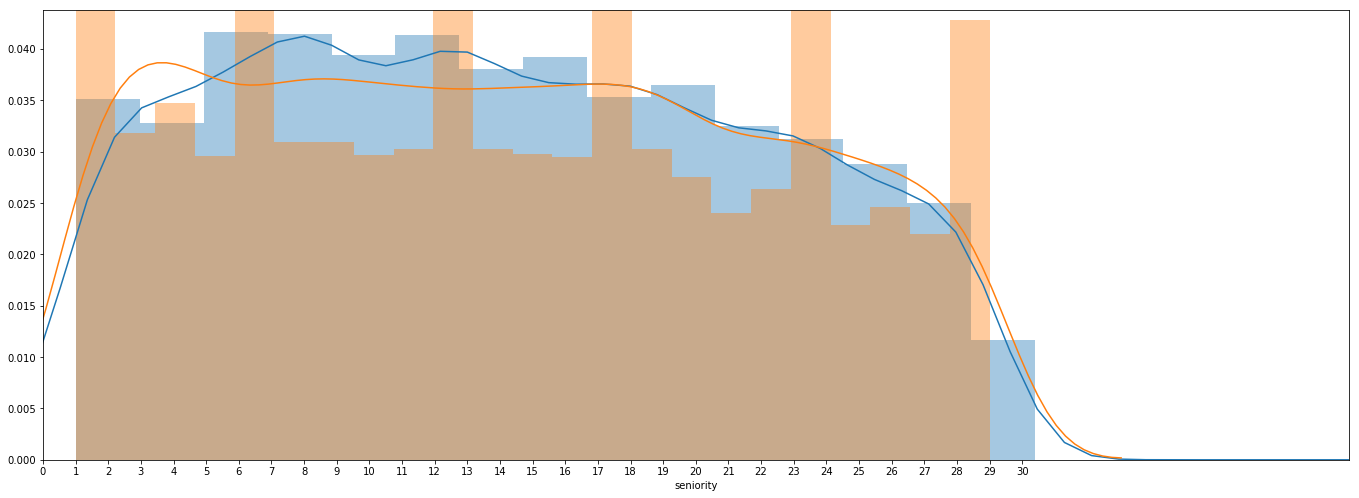

In [17]:
a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_df['duration'])
ax = sn.distplot(a=stayed_df['duration'])
ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_df['salary'])
ax = sn.distplot(a=stayed_df['salary'])
# ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_df['seniority'])
ax = sn.distplot(a=stayed_df['seniority'])
ax.set_xticks(np.arange(0,31,1))
ax.set_autoscaley_on(False)
ax.set_xlim([0,40])
plt.show()


# 3 quit duration cohorts, some salary separation

In [18]:
def split_quit_trimodal():
    early_break = 500
    late_break = 900
    quit_df, stayed_df = split_quit()
    quit_early_df = quit_df.where(quit_df['duration'] <= early_break).dropna(how='all')
    quit_middle_df = quit_df.where((quit_df['duration'] > early_break) & (quit_df['duration'] <= late_break)).dropna(how='all')
    quit_late_df = quit_df.where(quit_df['duration'] > late_break).dropna(how='all')
    return quit_early_df, quit_middle_df, quit_late_df
quit_early_df, quit_middle_df, quit_late_df = split_quit_trimodal()

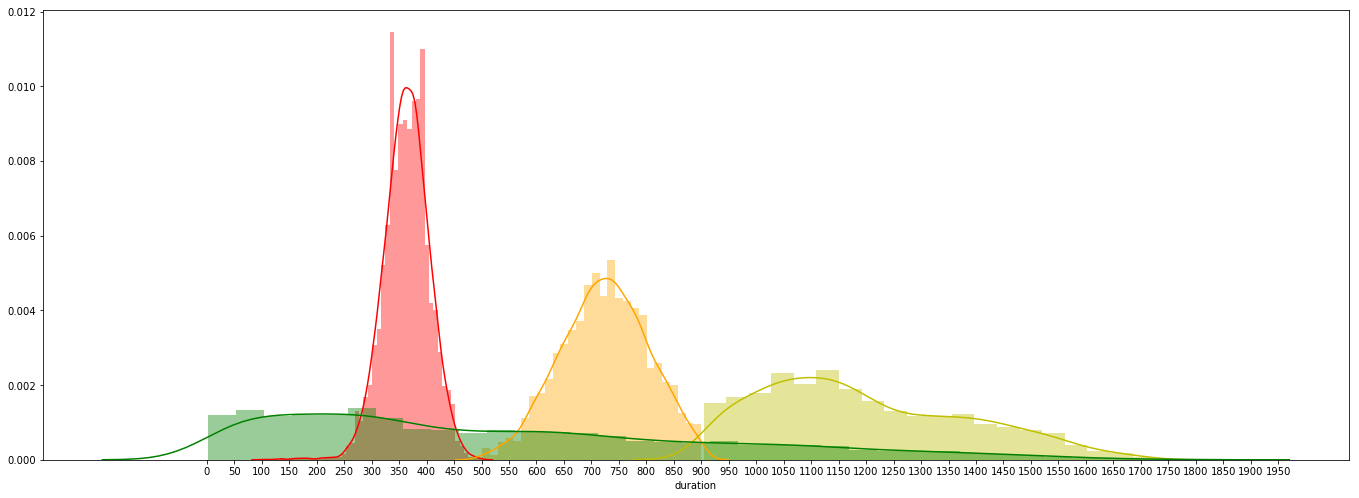

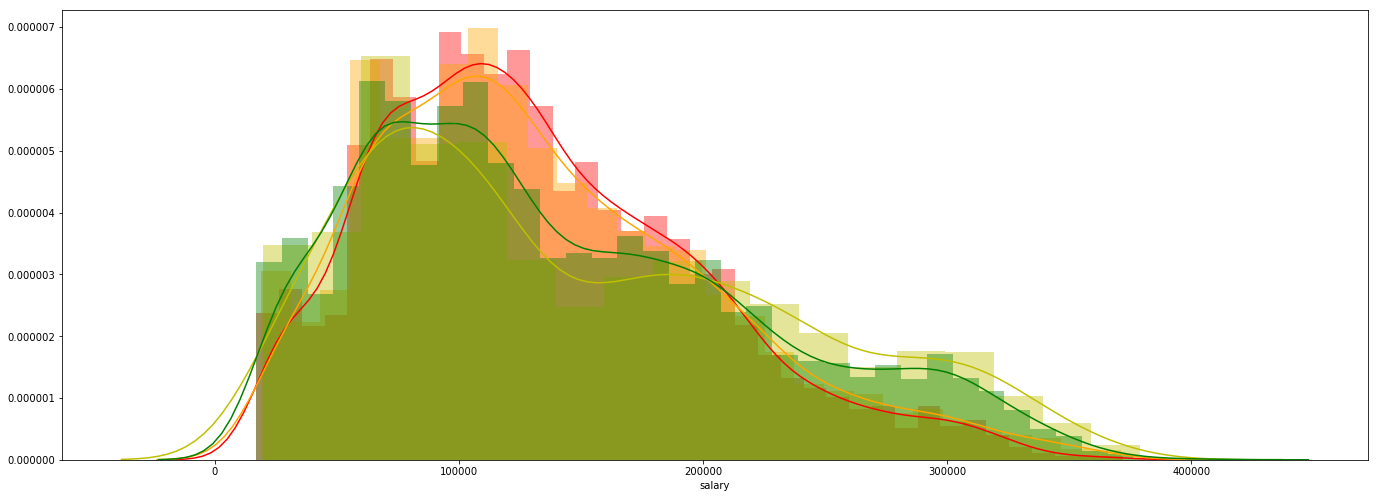

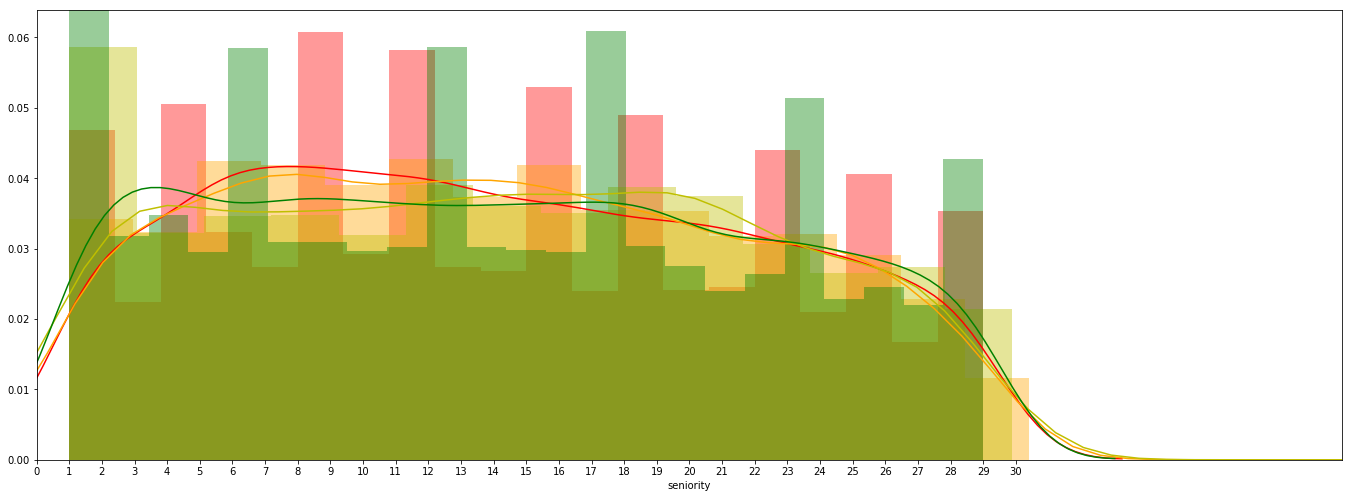

In [19]:
a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df['duration'], color='red')
ax = sn.distplot(a=quit_middle_df['duration'], color='orange')
ax = sn.distplot(a=quit_late_df['duration'], color='y')
ax = sn.distplot(a=stayed_df['duration'], color='green')
ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df['salary'], color='red')
ax = sn.distplot(a=quit_middle_df['salary'], color='orange')
ax = sn.distplot(a=quit_late_df['salary'], color='y')
ax = sn.distplot(a=stayed_df['salary'], color='green')
# ax.set_xticks(np.arange(0,2000,50))
plt.show()
# a4_dims = (11.7*2, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df['seniority'], color='red')
ax = sn.distplot(a=quit_middle_df['seniority'], color='orange')
ax = sn.distplot(a=quit_late_df['seniority'], color='y')
ax = sn.distplot(a=stayed_df['seniority'], color='green')
ax.set_xticks(np.arange(0,31,1))
ax.set_autoscaley_on(False)
ax.set_xlim([0,40])
plt.show()

# intution seems to hold, but data is still too noisy

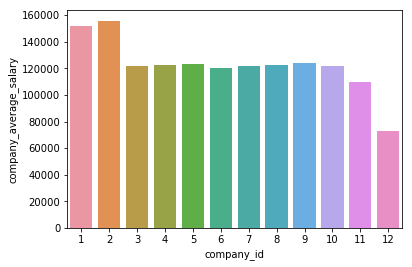

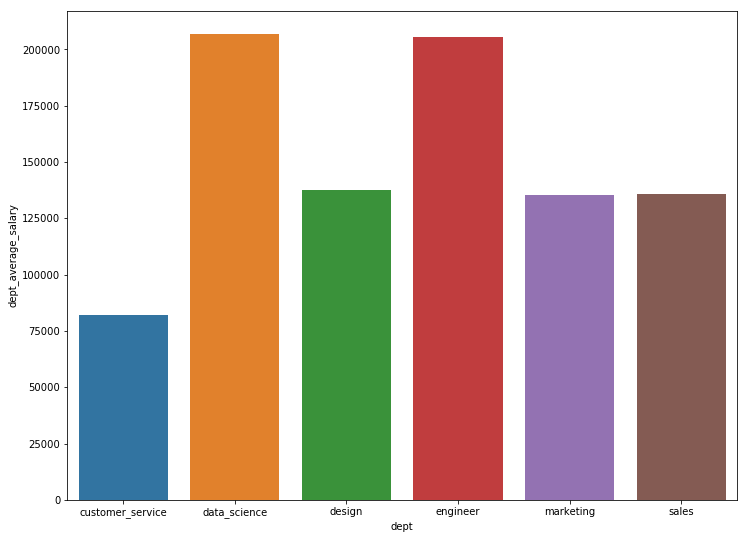

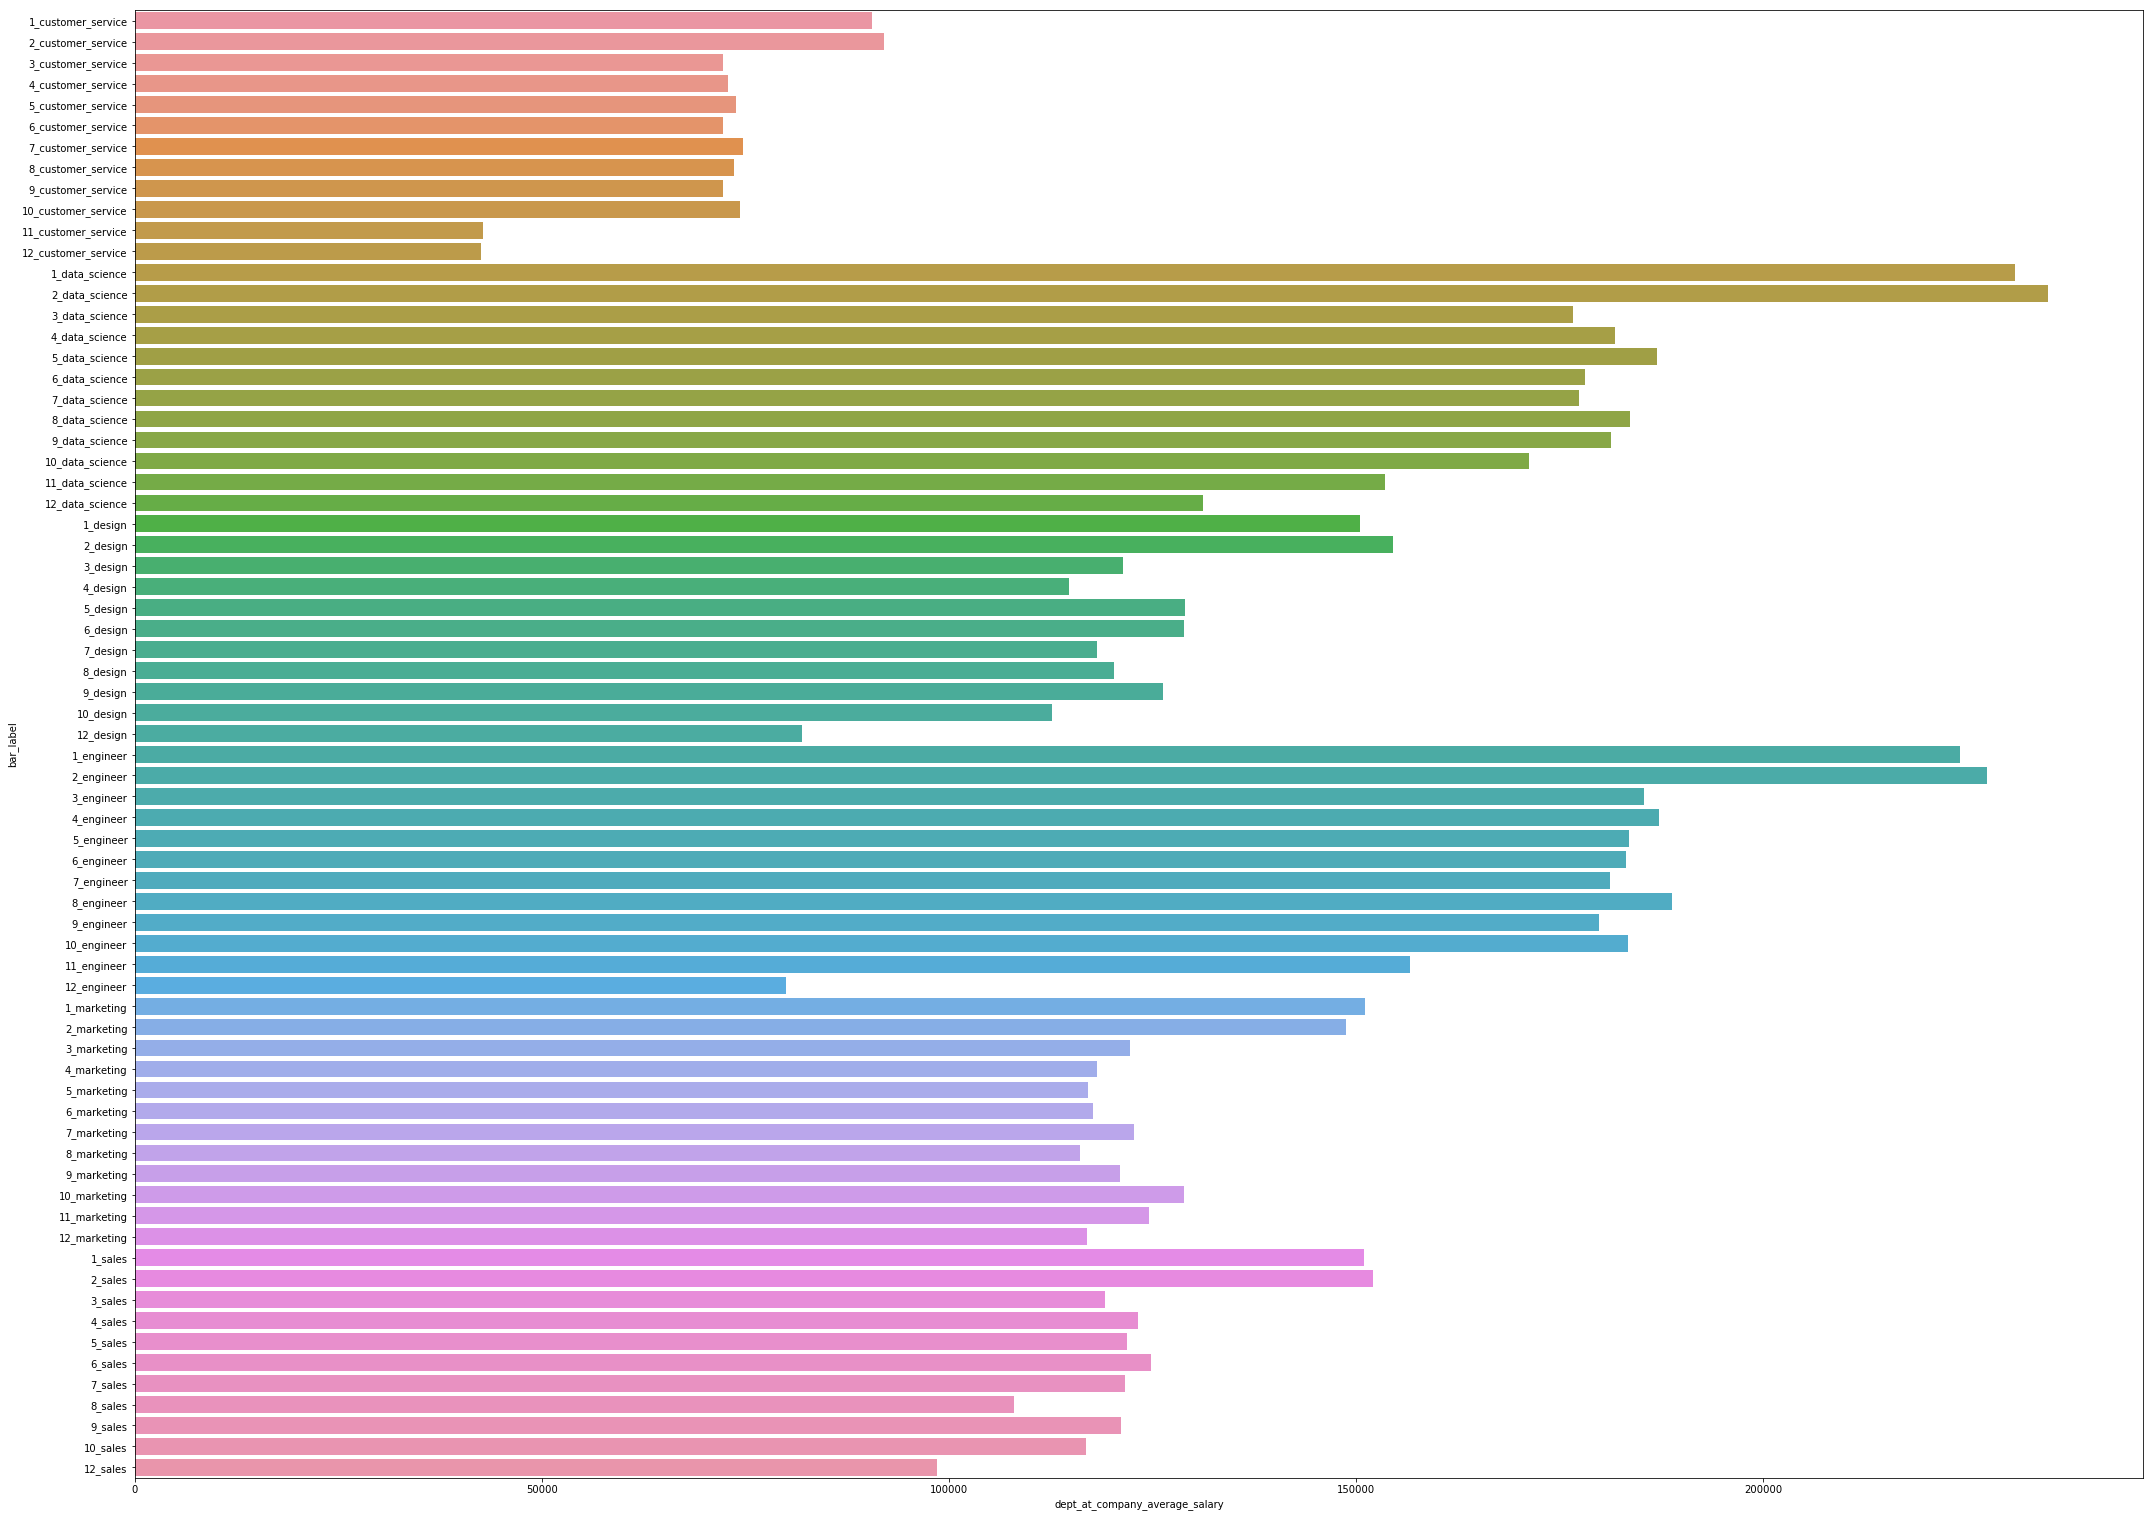

In [67]:
comp_sal = df[['company_id','salary', 'dept']].groupby('company_id').mean().reset_index(level=['company_id']).rename(columns={'salary':'company_average_salary'})
dept_sal = df[[ 'salary', 'dept']].groupby('dept').mean().reset_index(level=['dept']).rename(columns={'salary':'dept_average_salary'})
dept_comp_sal = df[['company_id','salary', 'dept']].groupby(['dept', 'company_id']).mean().reset_index(level=['dept','company_id']).rename(columns={'salary':'dept_at_company_average_salary'})
sn.barplot(x='company_id', y='company_average_salary', data=comp_sal)
dept_comp_sal['bar_label'] = dept_comp_sal['company_id'].astype(str) + '_' + dept_comp_sal['dept']
plt.show()
dims = (12, 9)
fig, ax = plt.subplots(figsize=dims)
sn.barplot(x='dept', y='dept_average_salary', data=dept_sal, ax=ax)
plt.show()
dims = (36, 27)
fig, ax = plt.subplots(figsize=dims)
sn.barplot(y='bar_label', x='dept_at_company_average_salary', data=dept_comp_sal, ax=ax)
plt.show()


# average values for salary across entire job market, across departments, across companies, and across dept/company pairings might be explanatory, as they are variable

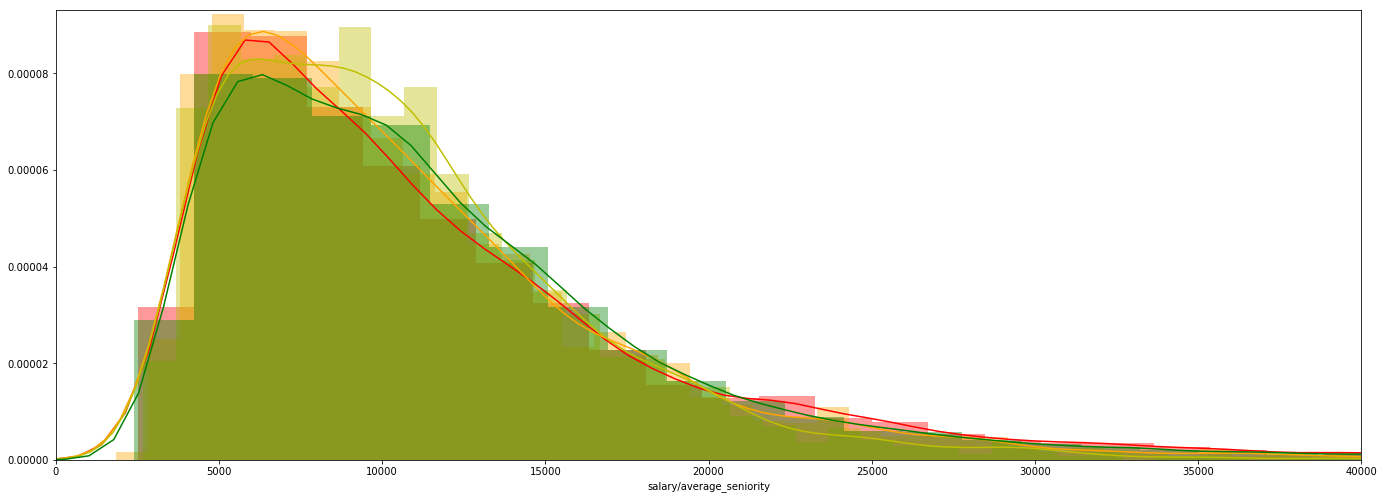

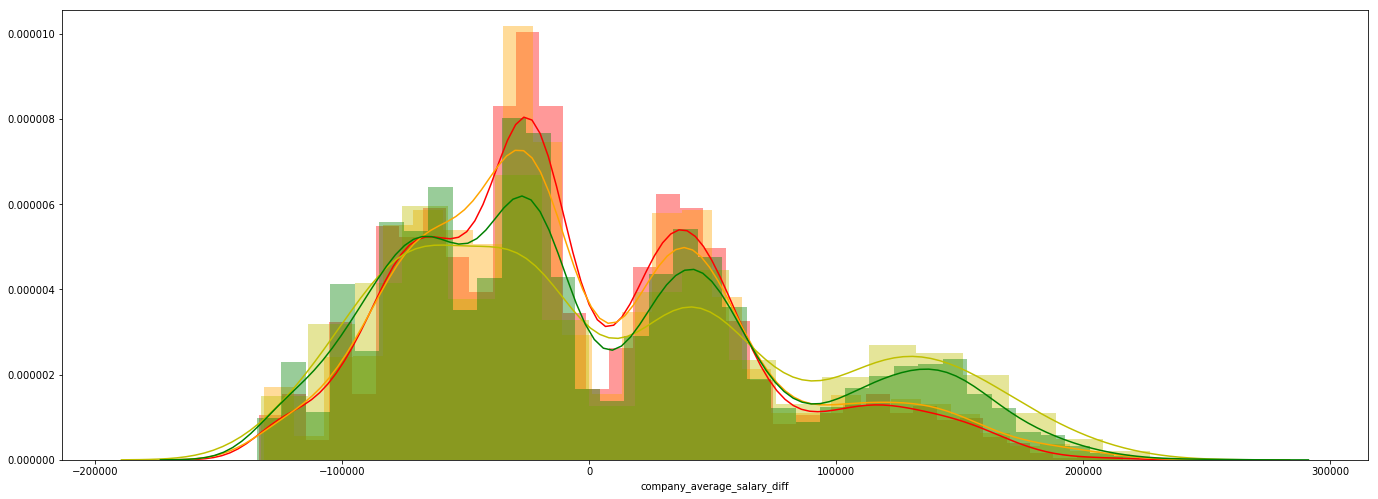

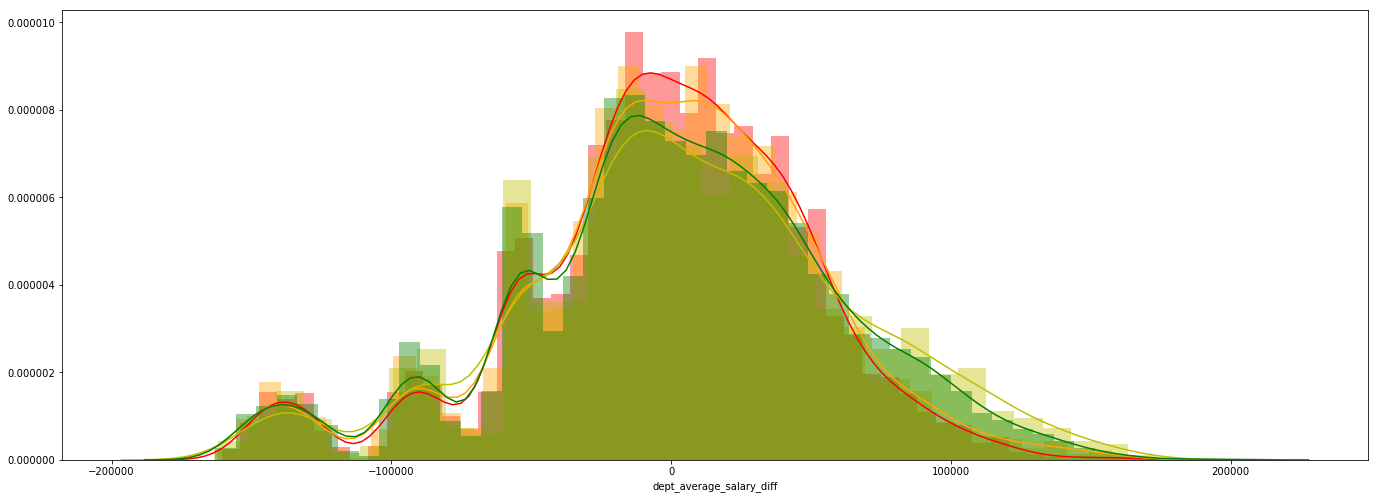

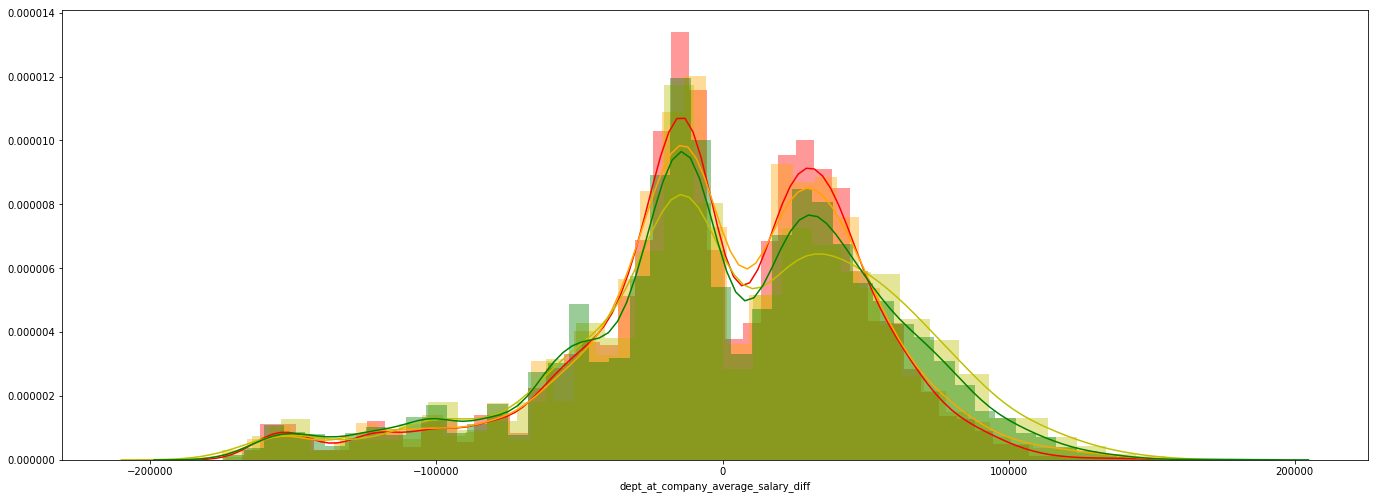

In [40]:
col_label = 'salary/average_seniority'
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df[col_label], color='red')
ax = sn.distplot(a=quit_middle_df[col_label], color='orange')
ax = sn.distplot(a=quit_late_df[col_label], color='y')
ax = sn.distplot(a=stayed_df[col_label], color='green')
# ax.set_xticks(np.arange(0,31,1))
# ax.set_autoscaley_on(False)
ax.set_xlim([0,40000])
plt.show()
# df['company_average_salary_diff'] = df['salary'] - df['company_average_salary']
# df['dept_average_salary_diff'] = df['salary'] - df['dept_average_salary']
# df['dept_at_company_average_salary_diff'] = df['salary'] - df['dept_at_company_average_salary']
col_label = 'company_average_salary_diff'
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df[col_label], color='red')
ax = sn.distplot(a=quit_middle_df[col_label], color='orange')
ax = sn.distplot(a=quit_late_df[col_label], color='y')
ax = sn.distplot(a=stayed_df[col_label], color='green')
# ax.set_xticks(np.arange(0,31,1))
# ax.set_autoscaley_on(False)
# ax.set_xlim([0,40000])
plt.show()
col_label = 'dept_average_salary_diff'
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df[col_label], color='red')
ax = sn.distplot(a=quit_middle_df[col_label], color='orange')
ax = sn.distplot(a=quit_late_df[col_label], color='y')
ax = sn.distplot(a=stayed_df[col_label], color='green')
# ax.set_xticks(np.arange(0,31,1))
# ax.set_autoscaley_on(False)
# ax.set_xlim([0,40000])
plt.show()
col_label = 'dept_at_company_average_salary_diff'
fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.distplot(a=quit_early_df[col_label], color='red')
ax = sn.distplot(a=quit_middle_df[col_label], color='orange')
ax = sn.distplot(a=quit_late_df[col_label], color='y')
ax = sn.distplot(a=stayed_df[col_label], color='green')
# ax.set_xticks(np.arange(0,31,1))
# ax.set_autoscaley_on(False)
# ax.set_xlim([0,40000])
plt.show()

# Additional separation possible on these values, but only applicable to some small subsets, available features do not fully explain the quitting

In [21]:
def split_stayed_4modal():
    pre_early_break = 200
    early_break = 500
    late_break = 900
    quit_df, stayed_df = split_quit()
    stayed_new_df = quit_df.where(stayed_df['duration'] <= pre_early_break).dropna(how='all')
    stayed_during_1st_quit_df = stayed_df.where((stayed_df['duration'] < pre_early_break) & (stayed_df['duration'] >= early_break)).dropna(how='all')
    stayed_post_1st_quit_df = stayed_df.where((stayed_df['duration'] > early_break) & (stayed_df['duration'] <= late_break)).dropna(how='all')
    stayed_post_2nd_quit_df = stayed_df.where(stayed_df['duration'] > late_break).dropna(how='all')
    return stayed_new_df, stayed_during_1st_quit_df, stayed_post_1st_quit_df, stayed_post_2nd_quit_df


stayed_new_df, stayed_during_1st_quit_df, stayed_post_1st_quit_df, stayed_post_2nd_quit_df = split_stayed_4modal()

In [22]:
stayed_post_1st_quit_df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,dept_at_company_average_salary,dept_average_salary,company_average_salary,...,time_until_quit,last_employment_day,duration,seniority_at_end,average_seniority,salary/average_seniority,quit,company_average_salary_diff,dept_average_salary_diff,dept_at_company_average_salary_diff
2,6808.0,4.0,data_science,26.0,230000.0,2013-08-26,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,839.0,28.0,27.0,8518.518519,0.0,107278.855480,23114.106583,48250.896057
16,59141.0,4.0,data_science,7.0,154000.0,2014-05-27,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,565.0,8.0,7.5,20533.333333,0.0,31278.855480,-52885.893417,-27749.103943
65,270271.0,4.0,data_science,3.0,68000.0,2013-12-19,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,724.0,4.0,3.5,19428.571429,0.0,-54721.144520,-138885.893417,-113749.103943
69,282308.0,4.0,data_science,14.0,130000.0,2014-04-11,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,611.0,15.0,14.5,8965.517241,0.0,7278.855480,-76885.893417,-51749.103943
86,348075.0,4.0,data_science,23.0,266000.0,2013-07-22,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,874.0,25.0,24.0,11083.333333,0.0,143278.855480,59114.106583,84250.896057
96,401060.0,4.0,data_science,10.0,169000.0,2013-09-05,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,829.0,12.0,11.0,15363.636364,0.0,46278.855480,-37885.893417,-12749.103943
97,404352.0,4.0,data_science,28.0,280000.0,2013-10-28,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,776.0,30.0,29.0,9655.172414,0.0,157278.855480,73114.106583,98250.896057
120,458683.0,4.0,data_science,19.0,271000.0,2013-10-28,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,776.0,21.0,20.0,13550.000000,0.0,148278.855480,64114.106583,89250.896057
133,504583.0,4.0,data_science,24.0,244000.0,2014-06-30,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,531.0,25.0,24.5,9959.183673,0.0,121278.855480,37114.106583,62250.896057
155,596643.0,4.0,data_science,6.0,143000.0,2014-06-09,NaT,181749.103943,206885.893417,122721.144520,...,NaN,2015-12-13,552.0,7.0,6.5,22000.000000,0.0,20278.855480,-63885.893417,-38749.103943


In [23]:
quit_early_df['group'] = 'QuitEarly'
quit_middle_df['group'] = 'QuitMiddle'
quit_late_df['group'] = 'QuitLate'
# stayed_df['group'] = 'StillWorking'
stayed_new_df['group'] = 'StillWorkingNew'
stayed_during_1st_quit_df['group'] = 'StillWorkingDuring1stQuit'
stayed_post_1st_quit_df['group'] = 'StillWorkingPost1stQuit'
stayed_post_2nd_quit_df['group'] = 'StillWorkingPost2ndQuit'
labeled_df = pd.concat([quit_early_df, 
                        quit_middle_df, 
                        quit_late_df,
                        stayed_new_df,
                        stayed_during_1st_quit_df,
                        stayed_post_1st_quit_df,
                        stayed_post_2nd_quit_df
                       ])

In [24]:
labeled_df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,dept_at_company_average_salary,dept_average_salary,company_average_salary,...,last_employment_day,duration,seniority_at_end,average_seniority,salary/average_seniority,quit,company_average_salary_diff,dept_average_salary_diff,dept_at_company_average_salary_diff,group
6,28631.0,4.0,data_science,18.0,286000.0,2011-07-18,2012-09-07,181749.103943,206885.893417,122721.144520,...,2012-09-07,417.0,19.0,18.5,15459.459459,1.0,163278.855480,79114.106583,104250.896057,QuitEarly
7,30656.0,4.0,data_science,22.0,238000.0,2011-11-22,2012-12-21,181749.103943,206885.893417,122721.144520,...,2012-12-21,395.0,23.0,22.5,10577.777778,1.0,115278.855480,31114.106583,56250.896057,QuitEarly
10,36538.0,4.0,data_science,6.0,165000.0,2013-08-26,2014-08-15,181749.103943,206885.893417,122721.144520,...,2014-08-15,354.0,6.0,6.0,27500.000000,1.0,42278.855480,-41885.893417,-16749.103943,QuitEarly
11,40986.0,4.0,data_science,10.0,178000.0,2012-08-20,2013-10-11,181749.103943,206885.893417,122721.144520,...,2013-10-11,417.0,11.0,10.5,16952.380952,1.0,55278.855480,-28885.893417,-3749.103943,QuitEarly
14,49534.0,4.0,data_science,13.0,137000.0,2013-12-30,2014-12-12,181749.103943,206885.893417,122721.144520,...,2014-12-12,347.0,13.0,13.0,10538.461538,1.0,14278.855480,-69885.893417,-44749.103943,QuitEarly
15,53643.0,4.0,data_science,7.0,160000.0,2014-10-06,2015-10-30,181749.103943,206885.893417,122721.144520,...,2015-10-30,389.0,8.0,7.5,21333.333333,1.0,37278.855480,-46885.893417,-21749.103943,QuitEarly
22,69416.0,4.0,data_science,10.0,133000.0,2012-04-09,2013-03-15,181749.103943,206885.893417,122721.144520,...,2013-03-15,340.0,10.0,10.0,13300.000000,1.0,10278.855480,-73885.893417,-48749.103943,QuitEarly
33,131274.0,4.0,data_science,8.0,152000.0,2013-07-22,2014-06-13,181749.103943,206885.893417,122721.144520,...,2014-06-13,326.0,8.0,8.0,19000.000000,1.0,29278.855480,-54885.893417,-29749.103943,QuitEarly
36,135649.0,4.0,data_science,22.0,258000.0,2014-02-24,2015-01-02,181749.103943,206885.893417,122721.144520,...,2015-01-02,312.0,22.0,22.0,11727.272727,1.0,135278.855480,51114.106583,76250.896057,QuitEarly
38,150059.0,4.0,data_science,20.0,269000.0,2014-04-28,2015-04-06,181749.103943,206885.893417,122721.144520,...,2015-04-06,343.0,20.0,20.0,13450.000000,1.0,146278.855480,62114.106583,87250.896057,QuitEarly


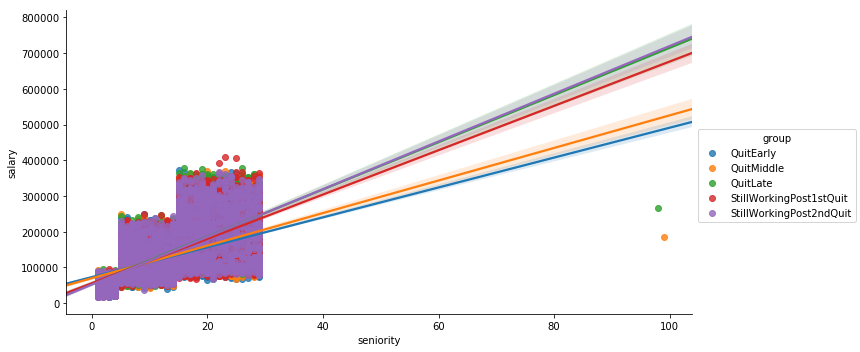

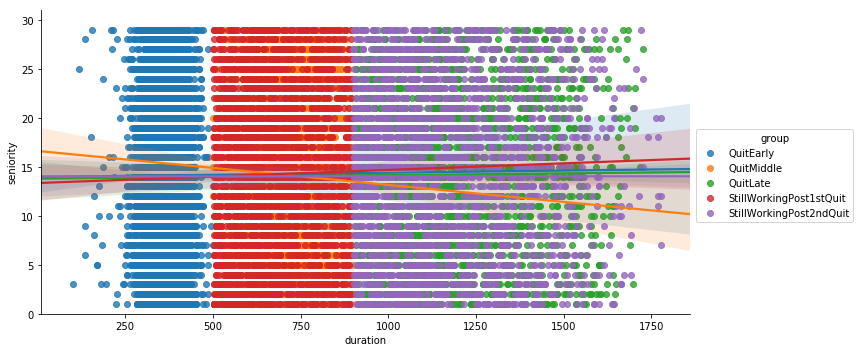

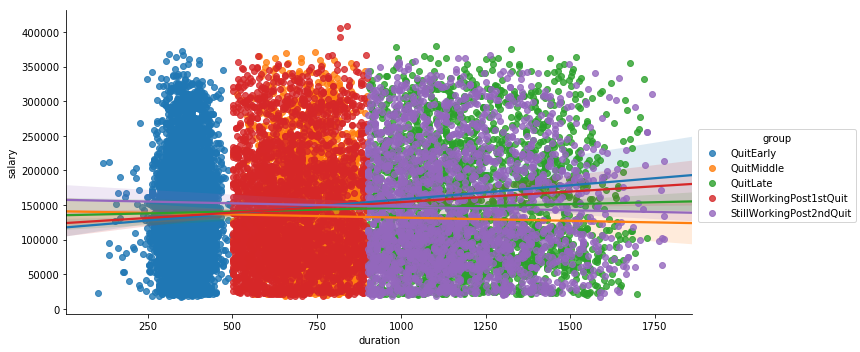

In [25]:

# fig, ax = plt.subplots(figsize=a4_dims)
ax = sn.lmplot(x='seniority', y='salary', data=labeled_df, hue='group', aspect=2)
plt.show()
ax = sn.lmplot(x='duration', y='seniority', data=labeled_df, hue='group', aspect=2)
ax.axes[0,0].set_ylim([0,31])
plt.show()
ax = sn.lmplot(x='duration', y='salary', data=labeled_df, hue='group', aspect=2)
plt.show()

# Scatterplot and linear fit of feature pairs by group
- Distinct trend of lower seniority / salary ratio for early and middle quitters
- More middle quitters seem to have been higher seniority
- More early quitters sem to have been of lower seniority
- early quitters had positive salary / duration correlation, despite negative seniority / salary correlations, with similar values to those who were still working at end post quit 1 timeframe
- middle quitters had a lower salary / duration correlation than the rest.

In [26]:
ax = sn.distplot(a=ds_cid['duration'])

In [27]:
std_scale = StandardScaler()
minmax_scale = MinMaxScaler()
maxabs_scale = MaxAbsScaler()
robust_scale = RobustScaler()

In [28]:
ids = labeled_df[['employee_id', 'group']].copy()
X = labeled_df[[
    'company_id',
    'dept_as_int',
    'average_seniority', 
    'salary', 
    'salary/average_seniority',
    'company_average_salary_diff', 
    'dept_average_salary_diff',
    'dept_at_company_average_salary_diff'
]].copy()
Y = labeled_df[['quit', 'duration', 'group']].copy()
Y['quit'] = Y['quit'] == 1.0

In [29]:
X['salary'] = robust_scale.fit_transform(X['salary'].values.reshape(-1, 1))
X['salary/average_seniority'] = robust_scale.fit_transform(X['salary/average_seniority'].values.reshape(-1, 1))
X['company_average_salary_diff'] = robust_scale.fit_transform(X['company_average_salary_diff'].values.reshape(-1, 1))
X['dept_average_salary_diff'] = robust_scale.fit_transform(X['dept_average_salary_diff'].values.reshape(-1, 1))
X['dept_at_company_average_salary_diff'] = robust_scale.fit_transform(X['dept_at_company_average_salary_diff'].values.reshape(-1, 1))
X['company_id'] = pd.Categorical(X['company_id'])
X['dept_as_int'] = pd.Categorical(X['dept_as_int'])

In [30]:
from sksurv.nonparametric import kaplan_meier_estimator
# X

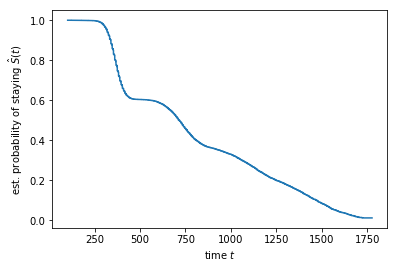

In [68]:
time, survival_prob = kaplan_meier_estimator(Y['quit'], Y['duration'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of staying $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

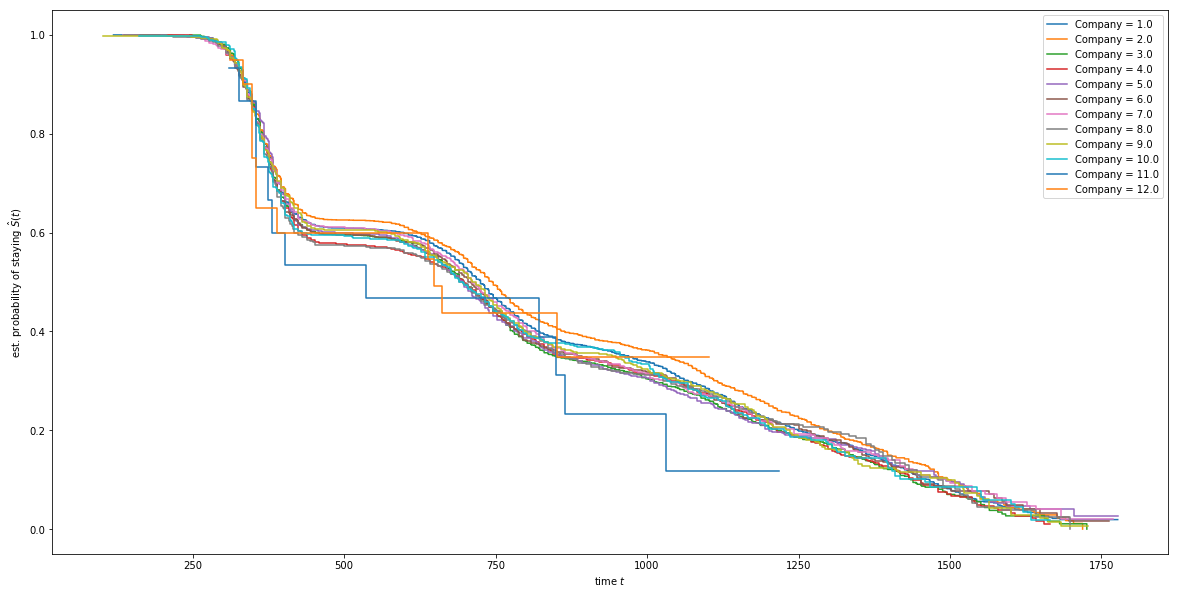

In [32]:
plt.figure(figsize=(20,10))
for company in sorted(labeled_df['company_id'].unique()):
    mask_comp = X["company_id"] == company
    time_comp, survival_prob_comp = kaplan_meier_estimator(
        Y["quit"][mask_comp],
        Y["duration"][mask_comp])
    plt.step(time_comp, survival_prob_comp, where="post",
             label="Company = %s" % company)

plt.ylabel("est. probability of staying $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

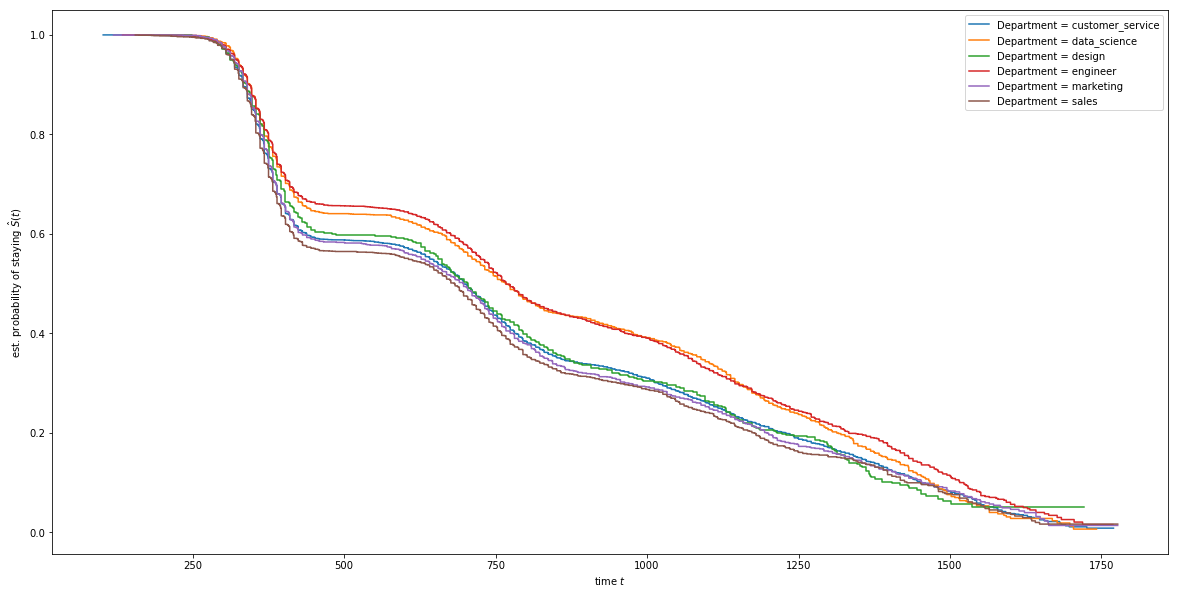

In [33]:
plt.figure(figsize=(20,10))
for dept in sorted(labeled_df['dept_as_int'].unique()):
    mask_dept = X["dept_as_int"] == dept
    time_dept, survival_prob_dept = kaplan_meier_estimator(
        Y["quit"][mask_dept],
        Y["duration"][mask_dept])
    plt.step(time_dept, survival_prob_dept, where="post",
             label="Department = %s" % dept_enc.inverse_transform(int(dept)))
plt.ylabel("est. probability of staying $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

In [122]:
ohe = OneHotEncoder()
X_enc = ohe.fit_transform(X)
Ytemp = Y.copy()
del Ytemp['group']
# print(Ytemp.columns)
y = np.asarray(Ytemp.to_records(index=False))
# np.asarray(y)

/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/sksurv/column.py:147: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  cat = pandas.Categorical.from_array(pandas.Series(data))


In [123]:
x_train, x_test, y_train, y_test, ids_train, ids_test = train_test_split(X_enc,y,ids, train_size=0.80, test_size=0.20,stratify=ids['group'])

In [124]:
print(y_train)
coxph = CoxPHSurvivalAnalysis()
coxph.fit(x_train, y_train)


[( True,  340.) (False,  678.) ( True,  347.) ..., ( True,  263.)
 ( True,  704.) (False,  524.)]


/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.276087320498907e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.9577734314275937e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.838911197022223e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=False)

In [137]:
feature_vals = pd.Series(coxph.coef_, index=x_train.columns)
feature_vals[feature_vals.abs().sort_values(ascending=False).index]

dept_average_salary_diff              -0.792643
dept_as_int=3.0                       -0.783113
dept_at_company_average_salary_diff    0.731831
dept_as_int=1.0                       -0.722271
company_id=12.0                       -0.654281
company_average_salary_diff            0.573633
salary                                -0.517360
company_id=11.0                       -0.420030
company_id=7.0                        -0.390708
salary/average_seniority               0.365190
company_id=10.0                       -0.363547
company_id=8.0                        -0.352340
company_id=6.0                        -0.349462
company_id=9.0                        -0.347197
company_id=3.0                        -0.333647
company_id=5.0                        -0.333497
company_id=4.0                        -0.328462
dept_as_int=2.0                       -0.257554
dept_as_int=4.0                       -0.224336
dept_as_int=5.0                       -0.184598
company_id=2.0                        -0

In [71]:
y_train

rec.array([( True,   290., 'QuitEarly'),
           (False,   885., 'StillWorkingPost1stQuit'),
           ( True,   375., 'QuitEarly'), ...,
           (False,   719., 'StillWorkingPost1stQuit'),
           ( True,  1250., 'QuitLate'), ( True,   459., 'QuitEarly')], 
          dtype=[('quit', '?'), ('duration', '<f8'), ('group', 'O')])

In [138]:
train_pred = coxph.predict_survival_function(x_train.loc[1])

In [139]:
train_pred


array([ StepFunction(x=array([  102.,   119.,   134., ...,  1769.,  1770.,  1777.]), y=array([  9.99896674e-01,   9.99793352e-01,   9.99690035e-01, ...,
         6.89563457e-04,   6.89563457e-04,   6.89563457e-04]))], dtype=object)

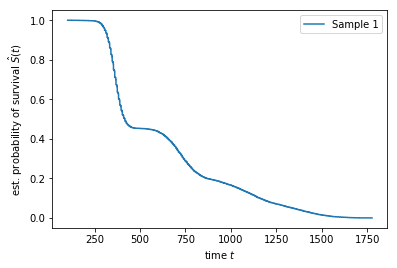

In [140]:
for i, c in enumerate(train_pred):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

In [75]:
X_without_comp_dept = X.copy()
del X_without_comp_dept['dept_as_int']
del X_without_comp_dept['company_id']
X_train, X_test, Y_train, Y_test, ids_clf_train, ids_clf_test = train_test_split(X_without_comp_dept,Y,ids, train_size=0.80, test_size=0.20,stratify=ids['group'])

In [76]:
clf = DecisionTreeClassifier()
clf2 = DecisionTreeClassifier()

In [77]:
clf.fit(X_train, Y_train['group'])
clf2.fit(X_without_comp_dept, Y['group'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [78]:
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)
preds = clf2.predict(X_without_comp_dept)

In [79]:
print(classification_report(Y_train['group'], train_preds))
print(classification_report(Y_test['group'], test_preds))
print(classification_report(Y['group'], preds))

                         precision    recall  f1-score   support

              QuitEarly       0.89      0.99      0.94      5874
               QuitLate       0.91      0.91      0.91      1958
             QuitMiddle       0.94      0.89      0.92      2976
StillWorkingPost1stQuit       0.97      0.86      0.91      2298
StillWorkingPost2ndQuit       0.99      0.84      0.91      1729

            avg / total       0.93      0.92      0.92     14835

                         precision    recall  f1-score   support

              QuitEarly       0.43      0.45      0.44      1468
               QuitLate       0.15      0.16      0.16       490
             QuitMiddle       0.21      0.20      0.20       744
StillWorkingPost1stQuit       0.14      0.13      0.14       575
StillWorkingPost2ndQuit       0.16      0.16      0.16       432

            avg / total       0.27      0.28      0.27      3709

                         precision    recall  f1-score   support

              Quit

In [80]:
# from sklearn.metrics import confusion_matrix

# pd.DataFrame(
#     confusion_matrix(Y_test['quit'], test_preds),
#     columns=['Predicted Not Quit', 'Predicted Quit'],
#     index=['True Not Quit', 'True Quit']
# )

In [81]:
feat_imp_df = pd.DataFrame()
feat_imp_df['features'] = X_without_comp_dept.columns
feat_imp_df['importance'] = clf2.feature_importances_
feat_imp_df = feat_imp_df.set_index('features')

In [82]:
feat_imp_df.sort_values(by='importance', ascending=False)

,importance
features,
salary/average_seniority,0.230152
dept_at_company_average_salary_diff,0.224251
company_average_salary_diff,0.203958
average_seniority,0.136340
dept_average_salary_diff,0.125635
salary,0.079663


In [83]:
from sklearn.ensemble import AdaBoostClassifier
clf3 = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=150)
clf3.fit(X_train, Y_train['quit'])
quad_train_preds = clf3.predict(X_train)
quad_test_preds = clf3.predict(X_test)
print(classification_report(Y_train['quit'], quad_train_preds))
print(classification_report(Y_test['quit'], quad_test_preds))

             precision    recall  f1-score   support

      False       0.90      0.97      0.93      4027
       True       0.99      0.96      0.97     10808

avg / total       0.96      0.96      0.96     14835

             precision    recall  f1-score   support

      False       0.29      0.22      0.25      1007
       True       0.73      0.80      0.76      2702

avg / total       0.61      0.64      0.62      3709



In [113]:
## from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifier, LogisticRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
# clf4 = AdaBoostClassifier(MultinomialNB(alpha=1e-6), n_estimators=150)
clf4 = LogisticRegression(penalty='l2', C=1e-3, solver='sag', max_iter=9000)
clf4.fit(X_train, Y_train['duration'])
quad_train_group_preds = clf4.predict(X_train)
quad_test_group_preds = clf4.predict(X_test)
# print(classification_report(Y_train['group'], quad_train_group_preds))
# print(classification_report(Y_test['group'], quad_test_group_preds))

/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
print(explained_variance_score(Y_train['duration'], quad_train_group_preds))
print(mean_squared_error(Y_train['duration'], quad_train_group_preds))
print(explained_variance_score(Y_train['duration'], quad_train_group_preds))
print(r2_score(Y_train['duration'], quad_train_group_preds))